In [21]:
import numpy as np
import struct
from array import array
from os.path import join

# https://www.kaggle.com/code/hojjatk/read-mnist-dataset
class MnistDataloader(object):
    def __init__(
        self,
        training_images_filepath,
        training_labels_filepath,
        test_images_filepath,
        test_labels_filepath,
    ):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath

    def read_images_labels(self, images_filepath, labels_filepath):
        labels = []
        with open(labels_filepath, "rb") as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError(
                    "Magic number mismatch, expected 2049, got {}".format(magic)
                )
            labels = array("B", file.read())

        with open(images_filepath, "rb") as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError(
                    "Magic number mismatch, expected 2051, got {}".format(magic)
                )
            image_data = array("B", file.read())
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols : (i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img

        return images, labels

    def load_data(self):
        x_train, y_train = self.read_images_labels(
            self.training_images_filepath, self.training_labels_filepath
        )
        x_test, y_test = self.read_images_labels(
            self.test_images_filepath, self.test_labels_filepath
        )
        return (x_train, y_train), (x_test, y_test)

In [22]:
import random
import matplotlib.pyplot as plt

# https://www.kaggle.com/datasets/hojjatk/mnist-dataset?resource=download
input_path = "./input"
training_images_filepath = join(
    input_path, "train-images-idx3-ubyte/train-images-idx3-ubyte"
)
training_labels_filepath = join(
    input_path, "train-labels-idx1-ubyte/train-labels-idx1-ubyte"
)
test_images_filepath = join(input_path, "t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels_filepath = join(input_path, "t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")


def show_images(images, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(30, 20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if title_text != "":
            plt.title(title_text, fontsize=15)
        index += 1


mnist_dataloader = MnistDataloader(
    training_images_filepath,
    training_labels_filepath,
    test_images_filepath,
    test_labels_filepath,
)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

x_train3, y_train3, x_test3, y_test3 = [], [], [], []

even, odd = 0, 0
for i in range(0, 60_000, 3):
    tripple = x_train[i] + x_train[i + 1] + x_train[i + 2]
    x_train3.append(tripple)
    y_train3.append(y_train[i + 2] if y_train[i] % 2 else y_train[i + 1])
    if y_train[i] % 2:
        odd += 1
    else:
        even += 1
        
print("even", even, "odd", odd)
even, odd = 0, 0

for i in range(0, 10_000-1, 3):
    tripple = x_test[i] + x_test[i + 1] + x_test[i + 2]
    x_test3.append(tripple)
    y_test3.append(y_test[i + 2] if y_test[i] % 2 else y_test[i + 1])
    if y_test[i] % 2:
        odd += 1
    else:
        even += 1
print("even", even, "odd", odd)


images_2_show = []
titles_2_show = []
indices = []
for i in range(0, 10):
    r = random.randint(1, 20_000)
    images_2_show.append(x_train3[r])
    titles_2_show.append("training image [" + str(r) + "] = " + str(y_train3[r]))

for i in range(0, 5):
    indices.append(r := random.randint(1, 3_333))
    images_2_show.append(x_test3[r])
    titles_2_show.append("test image [" + str(r) + "] = " + str(y_test3[r]))

show_images(images_2_show, titles_2_show)

# distribution of classes
for i in range(0, 10):
    print(i, len([x for x in y_train3 if x == i]), len([x for x in y_test3 if x == i]))

even 9812 odd 10188
even 1657 odd 1676
0 2061 310
1 2171 412
2 2027 268
3 1896 376
4 2103 290
5 1735 342
6 2022 281
7 1994 370
8 2063 301
9 1928 383


In [23]:
import tensorflow as tf
from keras.utils import to_categorical

x_train = np.array(x_train3).reshape((-1, 84, 28, 1)) 
x_test = np.array(x_test3).reshape((-1, 84, 28, 1))

x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

y_test = to_categorical(y_test3)
y_train = to_categorical(y_train3)

In [24]:
from keras import layers
model = tf.keras.models.Sequential(
    [
        layers.Conv2D(32, (3, 3), activation="relu", input_shape=(84, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.Flatten(),
        layers.Dense(64, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5) 

Epoch 1/5


c:\Users\danie\Documents\SEM6\PUM\Lab7\venv\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


625/625 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.4824 - loss: 1.4271
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9314 - loss: 0.2121
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9719 - loss: 0.0938
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9828 - loss: 0.0569
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 23ms/step - accuracy: 0.9876 - loss: 0.0393


In [25]:
model.evaluate(x_test, y_test)

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9601 - loss: 0.1445


[0.10973474383354187, 0.9705970883369446]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Class: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Predicted class: 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted class: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Class: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Predicted class: 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Class: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Predicted class: 5


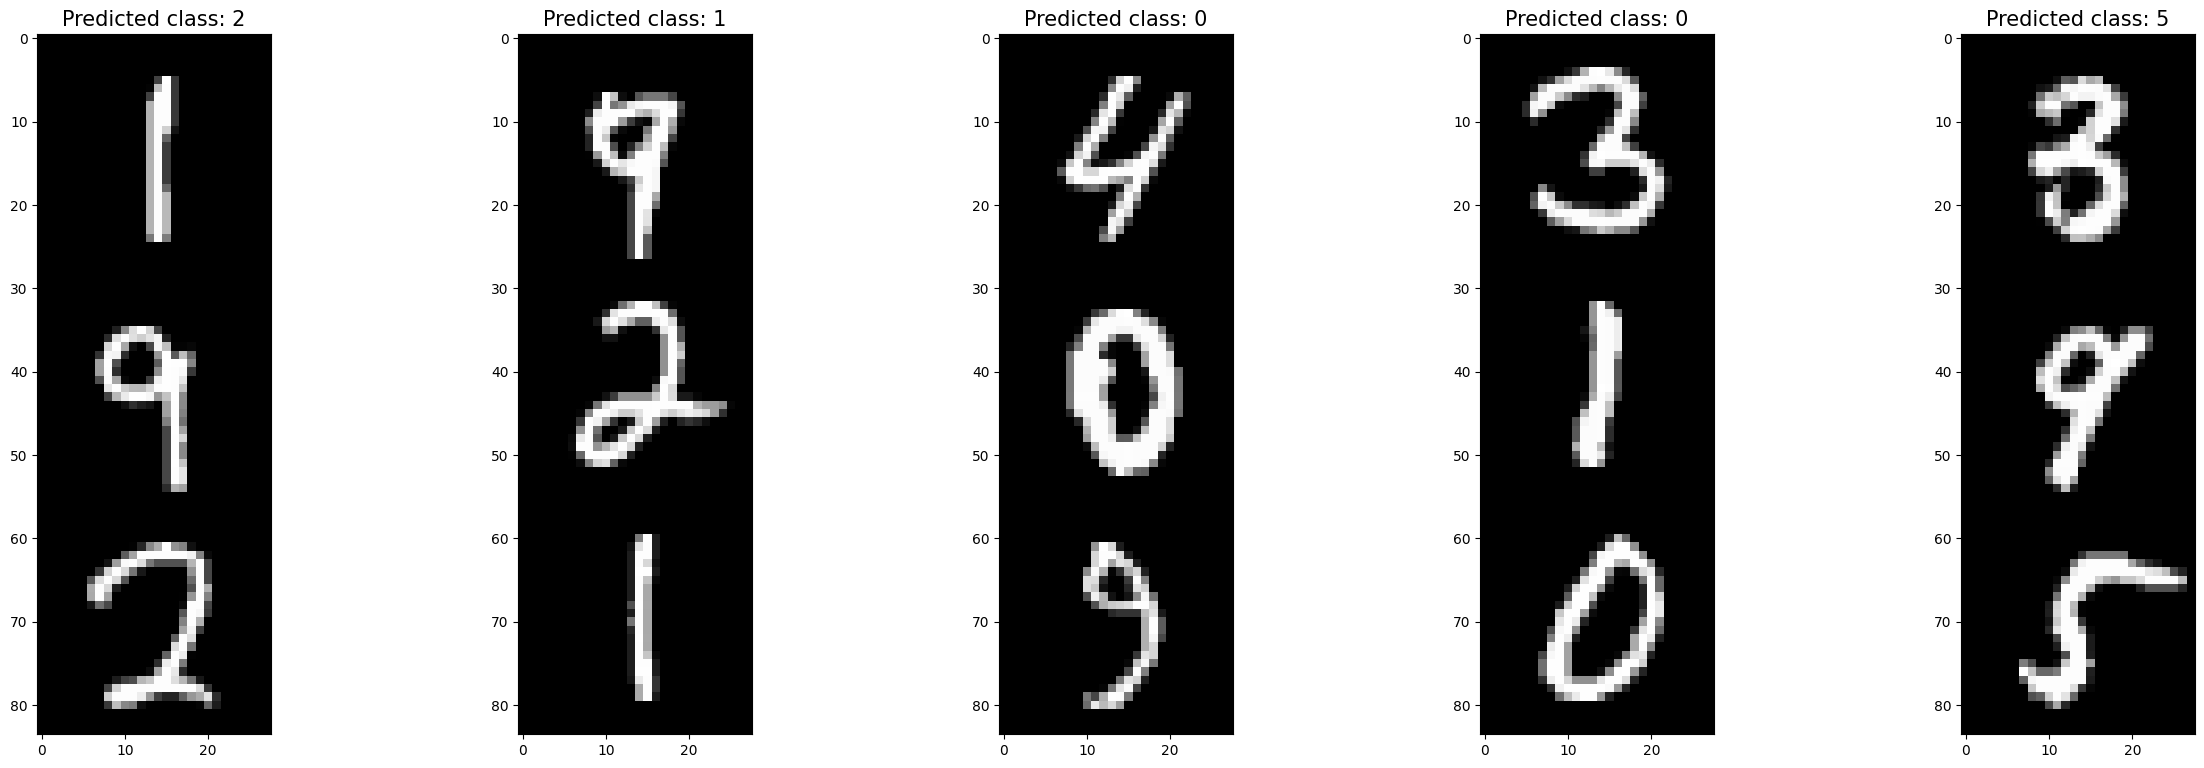

In [26]:
titles_2_show = []
for i in indices:
    sample = x_test[i]
    sample = np.expand_dims(sample, axis=0)

    predictions = model.predict(sample)
    predicted_class = np.argmax(predictions, axis=1)

    titles_2_show.append(f"Predicted class: {predicted_class[0]}")
    print(f"Class: {y_test[i]}")
    print(f"Predicted class: {predicted_class[0]}")

show_images(images_2_show[-5:], titles_2_show)